In [5]:
from __future__ import annotations
import random
from collections import deque
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import PIL.Image

In [6]:
env=gym.make('CartPole-v1' ,render_mode="rgb_array")

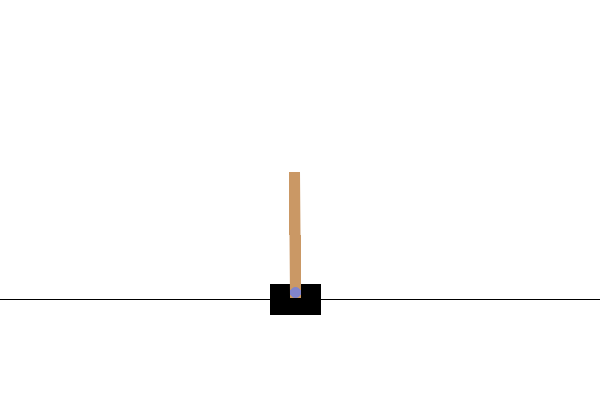

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

In [8]:
state_size=env.observation_space.shape
num_action=env.action_space.n
print(f"state size: {state_size} action:{num_action}" )

state size: (4,) action:2


In [9]:
init_state=env.reset()
init_state

(array([ 0.03287384,  0.04384588, -0.03856589, -0.02038275], dtype=float32),
 {})

In [10]:
def load_environment(training=True):
    env = gym.make(
        "CartPole-v1",
        render_mode=None if training else "human",
    )
    return env, env.observation_space.shape[0], env.action_space.n

def epsilon_decay(epsilon, epsilon_min, decay_method: callable):
    return max(epsilon_min, decay_method(epsilon))

def epsilon_greedy(env, policy_dqn, state, epsilon, device):
    if random.random() < epsilon:
        # Explore
        return env.action_space.sample()
    else:
        # Exploit
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_dqn(state)
        return q_values.argmax().item()

In [11]:
"""
DQN is an extension of Q-Learning where a neural network is used to approximate the Q-values. It combines reinforcement learning with deep learning, 
allowing the agent to handle complex environments with high-dimensional state spaces.
"""
class DeepQNetwork(nn.Module):

    layers: nn.Sequential

    def __init__(
            self: DeepQNetwork,
            state_space: int,
            action_space: int,
    ):
        super(DeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_space, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
class DQNCartPoleAgent:

    env: gym.Env
    state_space: int
    action_space: int

    def __init__(self):
        self.env, self.state_space, self.action_space = load_environment()

        # Set the device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {self.device}")

        # Initialize the DQN
        self.dpn = DeepQNetwork(self.state_space, self.action_space).to(self.device)

        # Initialize training parameters
        self.optimizer = optim.RMSprop
        self.criterion = nn.MSELoss()
        self.memory = deque(maxlen=10000) #buffer memory 

    def _remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def _act(self, state, epsilon):
        """
        Choose an action using an epsilon-greedy policy
        """
        if np.random.uniform() < epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            q_values = self.dpn(state)
            return torch.argmax(q_values).item()

    def _replay(self, batch_size, gamma, optimizer):
        """
        Train the DQN using experience replay
        """
        if len(self.memory) < batch_size:
            return  # Not enough memory to train

        batch = random.sample(self.memory, batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)

        # Compute the Q-values
        q_values = self.dpn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.dpn(next_states).max(1).values
        target_q_values = rewards + gamma * next_q_values * ~dones

        # Compute the loss L = ( Q(s, a) - ( r + gamma max_a' Q'(s', a') ) )^2
        loss = self.criterion(q_values, target_q_values.detach())

        # Update the DQN
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def load(self, path):
        """
        Load the DQN model weights
        """
        self.dpn.load_state_dict(torch.load(path))

    def save(self, path):
        """
        Save the DQN model weights
        """
        torch.save(self.dpn.state_dict(), path)

    def train(self,
              lr, gamma, epsilon, epsilon_min,
              n_episodes, batch_size,
              train_start):
        optimizer = self.optimizer(self.dpn.parameters(), lr=lr)

        # rewards = np.zeros(n_episodes)
        rewards = []
        episode_reward = 0
        episode = 0
        # for episode in range(n_episodes):
        while episode_reward < 1000:
            state = self.env.reset()[0]
            done = False

            episode_reward = 0
            while not done:
                # Choose an action using an epsilon-greedy policy
                action = self._act(state, epsilon)

                # Take the action, observe the reward and next state
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated

                # Penalize the agent for ending the episode early
                if terminated:
                    reward = -100

                # Store the experience in the replay buffer
                self._remember(state, action, reward, next_state, done)

                # Update the DQN using experience replay
                self._replay(batch_size, gamma, optimizer)

                state = next_state
                episode_reward += reward

            # Perform epsilon decay
            if epsilon > epsilon_min and len(self.memory) >= train_start:
                epsilon = epsilon_decay(epsilon, epsilon_min, lambda e: e * 0.999)

            # rewards[episode] = episode_reward
            rewards.append(episode_reward)

            if episode % 100 == 0:
                print(f"Episode: {episode:5d}, Epsilon: {epsilon:.2f}, Reward: {episode_reward:4.2f}")
            episode += 1

        print("Training complete with episode reward:", episode_reward)
        return rewards

    def test(self, truncate):
        env, _, _ = load_environment(training=False)

        state = env.reset()[0]
        terminated = False
        rewards = 0
        while not terminated:
            env.render()
            action = self._act(state, 0)
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            rewards += reward

            if rewards >= truncate:
                print(f"Truncate at {truncate} steps")
                break

            if rewards % (truncate // 10) == 0:
                print(f"Reached {rewards} steps")

        print("Test complete with reward:", rewards)
        env.close()

    def close(self):
        self.env.close()

Device: cpu
Episode:     0, Epsilon: 1.00, Reward: -82.00


/tmp/ipykernel_90490/3023974129.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(self.device)


Episode:   100, Epsilon: 0.94, Reward: -88.00
Episode:   200, Epsilon: 0.85, Reward: -86.00
Episode:   300, Epsilon: 0.77, Reward: -83.00
Episode:   400, Epsilon: 0.70, Reward: -79.00
Episode:   500, Epsilon: 0.63, Reward: -84.00
Episode:   600, Epsilon: 0.57, Reward: 26.00
Episode:   700, Epsilon: 0.52, Reward: -78.00
Episode:   800, Epsilon: 0.47, Reward: -77.00
Episode:   900, Epsilon: 0.42, Reward: -48.00
Episode:  1000, Epsilon: 0.38, Reward: 69.00
Episode:  1100, Epsilon: 0.35, Reward: -83.00
Episode:  1200, Epsilon: 0.31, Reward: -87.00
Episode:  1300, Epsilon: 0.28, Reward: -74.00
Episode:  1400, Epsilon: 0.26, Reward: -77.00
Episode:  1500, Epsilon: 0.23, Reward: -53.00
Episode:  1600, Epsilon: 0.21, Reward: 101.00
Episode:  1700, Epsilon: 0.19, Reward: -6.00
Episode:  1800, Epsilon: 0.17, Reward: -48.00
Episode:  1900, Epsilon: 0.16, Reward: -38.00
Episode:  2000, Epsilon: 0.14, Reward: -54.00
Training complete with episode reward: 2596.0


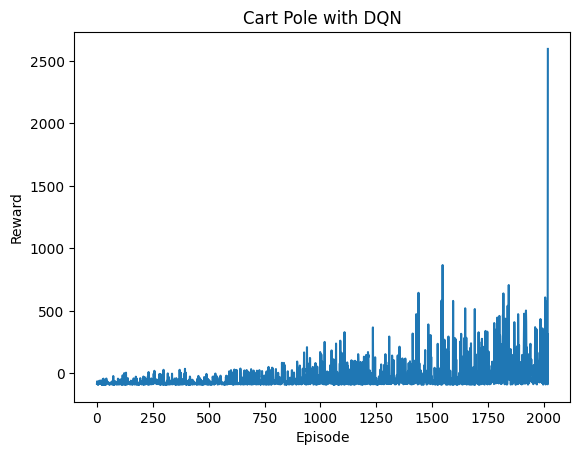

In [13]:
agent = DQNCartPoleAgent()

rewards = agent.train(
    lr=0.00025,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.001,
    n_episodes=2000,
    batch_size=64,
    train_start=1000
)

# Save the model
agent.save("output/cart_pole_dqn.pth")

# Plot the rewards
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Cart Pole with DQN")
plt.savefig("output/cart_pole_rewards.png")

agent.close()

In [14]:
agent = DQNCartPoleAgent()

agent.load("output/cart_pole_dqn.pth")
agent.test(200)
agent.close()

Device: cpu


/tmp/ipykernel_90490/3023974129.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dpn.load_state_dict(torch.load(path))


Reached 20.0 steps
Reached 40.0 steps
Reached 60.0 steps
Reached 80.0 steps
Reached 100.0 steps
Reached 120.0 steps
Reached 140.0 steps
Reached 160.0 steps
Reached 180.0 steps
Truncate at 200 steps
Test complete with reward: 200.0
